In [10]:
%run gravwell-lib.ipynb

# Intro

This notebook demonstrates how you can pull data from Gravwell queries into a Jupyter notebook.

Note the `%run gravwell-lib.ipynb` cell at the top--that imports the necessary code from another notebook residing in the current directory. To use Gravwell in your own notebook, copy that `gravwell-lib.ipynb` into the directory where *your* notebook resides and insert the same code cell at the top.

To pull data from Gravwell, we use the `query` function, which takes two arguments: the Gravwell query to run, and the duration over which to run. The duration is something like "-24h" or "-5m", to indicate "the last 24 hours" or "the last 5 minutes", respectively. You can also specify explicit start and end times, rather than a duration (demonstrated later in this notebook).

The `query` function returns a `pandas.DataFrame` object suitable for plotting and other manipulations.

### About the Demo Server

The queries in this notebook are executed against **demo.gravwell.io** (provided you haven't modified the `GravwellToken` and `GravwellServer` variables in `gravwell-lib.ipynb`).

This server has some basic data in the following tags:

* `pinger`: collects the round-trip time to various hosts on the Internet
* `stocks`: queries the Yahoo stocks API for stock market prices

# Raw Entries
To start with, we might pull back some raw entries from the `stocks` tag, filtering to only show 5 results for the AAPL ticker symbol:

In [11]:
raw = query("tag=* stats count", "-24h")
raw

,Timestamp,Source,Tag,Data
0,2022-08-31 10:06:18-06:00,192.168.254.87,syslog,count 2227011


Note how the DataFrame returned contains a Timestamp, Source, and Tag field in addition to the actual stocks data itself. If we want to see just the data fields, we can iterate over the results and print:

In [12]:
for x in raw["Data"]:
    print(x)

count 2227011


# Tables
Because the `query` function returns a pandas.DataFrame object, it's already essentially a table and thus we don't really need to do much to display our results. Here is a basic table query run over the last hour:

In [13]:
table = query("tag=pinger ax | stats mean(ms) as ms stddev(ms) by host ip | table protocol host ip ms stddev", "-1h")
table

,protocol,host,ip,ms,stddev
0,ICMP,ns1.google.com,216.239.32.10,63.783267,46.169929
1,ICMP,dns9.quad9.net,9.9.9.9,192.813231,45.456165
2,ICMP,resolver1.opendns.com,208.67.222.222,41.884444,45.959833
3,ICMP,www.gravwell.io,199.60.103.2,41.931303,46.309957
4,ICMP,one.one.one.one,1.1.1.1,41.957655,46.328081
5,ICMP,dns.google,8.8.8.8,48.870901,3.907428


# Charts
Now let's run a query using the chart renderer. Note that we call the same function as before: `query`. After running the query, if we just display the `chart` variable, we can see the data points rendered in a table:

In [14]:
chart = query("tag=pinger ax | stats mean(ms) by host | chart mean by host", "-1h")
chart

,Timestamp,dns.google,dns9.quad9.net,ns1.google.com,one.one.one.one,resolver1.opendns.com,www.gravwell.io
0,2022-09-01 09:06:26-06:00,47.7850,176.1935,46.5840,24.6480,24.8140,24.6510
1,2022-09-01 09:06:33.031250-06:00,47.6970,176.0100,46.4290,24.3580,24.6450,24.3380
2,2022-09-01 09:06:40.062500-06:00,47.7595,176.1190,46.5610,24.5995,24.6725,24.6060
3,2022-09-01 09:06:47.093750-06:00,47.7700,176.2880,46.5900,24.4780,25.0410,24.4650
4,2022-09-01 09:06:54.125000-06:00,47.8350,176.1640,46.5690,24.5250,24.8230,24.5350
...,...,...,...,...,...,...,...
507,2022-09-01 10:05:50.843750-06:00,47.9415,176.3915,46.6760,24.6600,24.8360,24.6810
508,2022-09-01 10:05:57.875000-06:00,47.7780,176.3120,46.7540,24.7260,24.7300,24.7230
509,2022-09-01 10:06:04.906250-06:00,48.0760,176.4730,47.0650,24.9690,24.9880,24.9750
510,2022-09-01 10:06:11.937500-06:00,47.8970,176.1695,48.6095,28.3490,28.8965,28.3545


To make a chart, we'll use the matplotlib library (imported in `gravwell-lib.ipynb` as `plt`). Here, we indicate that the column named "Timestamp" is the index column, then iterate over all the others to generate plots for each column.

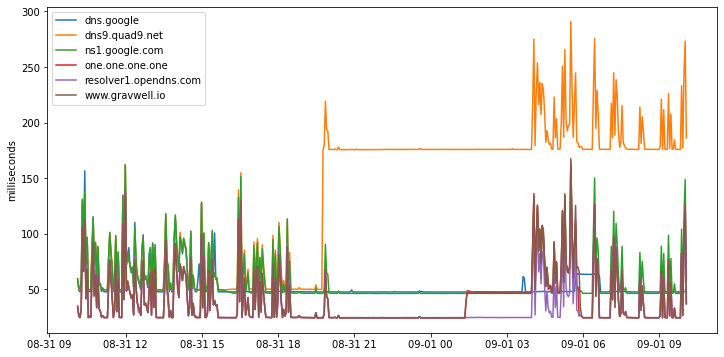

In [15]:
chart = query("tag=pinger ax | stats mean(ms) by host | chart mean by host", "-24h")
plt.figure(figsize=(12,6))
plt.ylabel("milliseconds")
for column_name in chart.set_index("Timestamp"):
    plt.plot(chart["Timestamp"],chart[column_name],label=column_name)
plt.legend()
plt.show()

If we're not interested in timeseries data, it makes more sense to run our query using the table renderer, then chart the results. Thus we can take the average response times from our earlier query and format it as a bar chart:

<AxesSubplot:xlabel='host'>

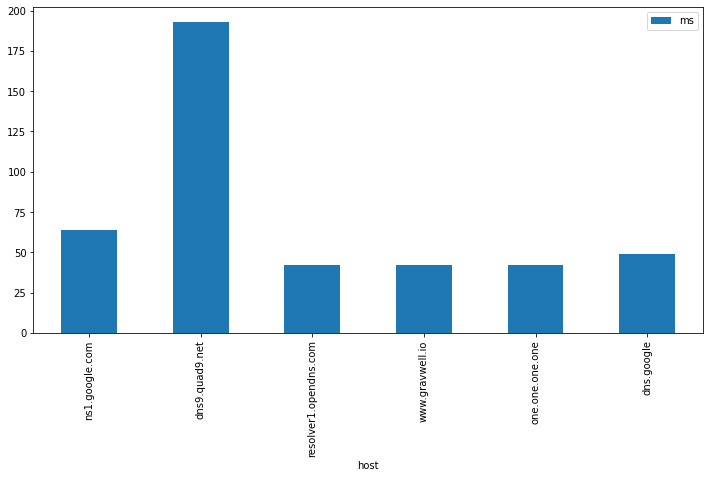

In [16]:
table.set_index("host").plot.bar(y="ms", figsize=(12, 6))

Of course we can also do interesting things like plot error bars using the standard deviation column:

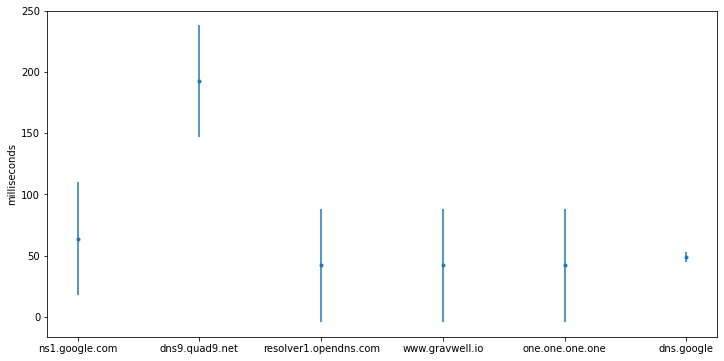

In [17]:
table = query("tag=pinger ax | stats mean(ms) as ms stddev(ms) by host ip | table protocol host ip ms stddev", "-1h")
plt.figure(figsize=(12,6))
plt.ylabel("milliseconds")
plt.errorbar(table["host"],table["ms"],fmt=".",yerr=table["stddev"])
plt.show()

# Specifying Exact Timeframes
Sometimes, "run the query over the last N hours" isn't good enough--you need to run the query over a particular time frame. Maybe you're building a notebook to investigate trends in the stock market between May 8 and May 14, 2022. In this case, you can specify the `start` and `end` parameters to the query function. These should be RFC3339 (ISO 8601) timestamp strings. You can generate those strings by hand, or you can use the datetime library:

In [18]:
now=datetime.datetime.now().astimezone().isoformat()
now

'2022-09-01T09:06:36.028029-07:00'

The `astimezone()` function with no arguments puts the timestamps into the local time zone. If we instead want UTC, we can specify a timezone as an argument:

In [19]:
start=datetime.datetime.fromisoformat('2022-05-08').astimezone(pytz.utc).isoformat()
end=datetime.datetime.fromisoformat('2022-05-14').astimezone(pytz.utc).isoformat()
start, end

('2022-05-08T07:00:00+00:00', '2022-05-14T07:00:00+00:00')

With `start` and `end` variables defined, we can pass them to a query and thus chart the number of `stocks` entries in those dates:

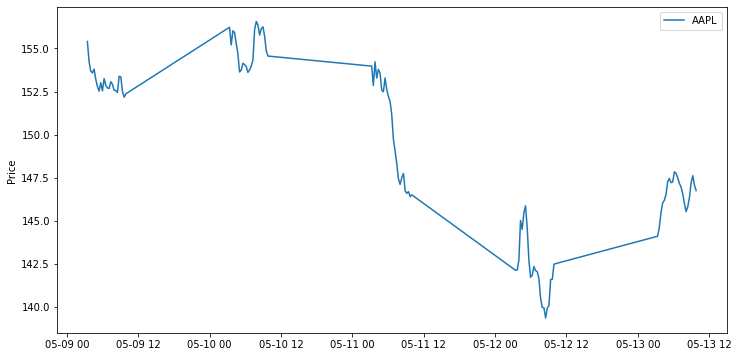

In [20]:
x = query("tag=stocks json Ticker==AAPL High | stats mean(High) by Ticker | chart mean by Ticker", start=start, end=end)
plt.figure(figsize=(12,6))
plt.ylabel("Price")
plt.plot(x["Timestamp"],x["AAPL"],label="AAPL")
plt.legend()
plt.show()

If we find the "jumps" between trading days to be confusing, we can instead use a scatter plot:

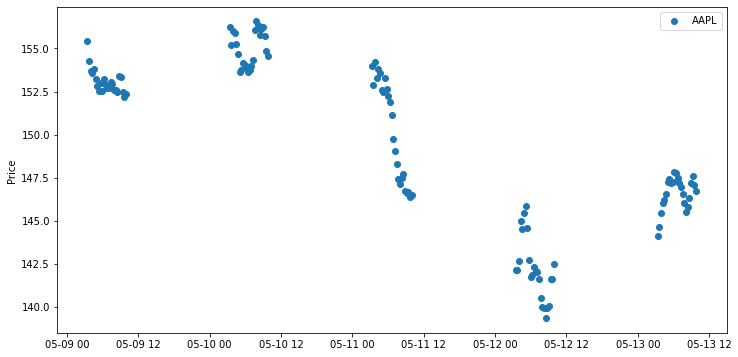

In [21]:
plt.figure(figsize=(12,6))
plt.ylabel("Price")
plt.scatter(x["Timestamp"],x["AAPL"],label="AAPL")
plt.legend()
plt.show()

# Getting Advanced
This final example shows how you can integrate data from Gravwell with all sorts of other Jupyter code. Here, I've adapted the [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet/) "WealthOfNations.ipynb" example notebook to instead show total connection counts for each country in the month of August, as derived from Zeek logs.

In [41]:
# This code is largely based on the WealthOfNations example in the ipyleaflet repo
# You may need to pip install ipyleaflet, bqplot, ipywidgets (see requirements.txt)
from ipywidgets import Dropdown, Layout
from bqplot import Lines, Figure, LinearScale, DateScale, Axis
from ipyleaflet import Map, GeoJSON, WidgetControl

# We're going to operate over the month of August 2022
start=datetime.datetime.fromisoformat('2022-08-01').astimezone(pytz.utc).isoformat()
end=datetime.datetime.fromisoformat('2022-08-31').astimezone(pytz.utc).isoformat()
date_start=pd.to_datetime(start)
date_end=pd.to_datetime(end)

date_scale = DateScale(min=date_start, max=date_end)
date_data = pd.date_range(start=date_start, end=date_end, freq="H", normalize=True)

# get the connection totals for each country so we can scale the colors on the map
totals = query("tag=zeekconn ax resp | ip resp !~ PRIVATE | geoip resp.CountryName | count by CountryName | table CountryName count", start=start, end=end)
biggest = 0
for x in totals["count"]:
    if x > biggest:
        biggest = x

In [42]:
# Now make a chart of total connections for each country.
data = query("tag=zeekconn ax resp | ip resp !~ PRIVATE | geoip resp.CountryName | count by CountryName over 1h | chart count by CountryName limit 200", start=start, end=end)
country_name = "United States"

In [43]:
# The x axis data is the timestamp
date_data = pd.DatetimeIndex(data["Timestamp"])

yscale = LinearScale()
# Here's where we put the data together: x axis is dates, y axis is connection counts
lines = Lines(x=date_data, y=data[country_name].values, scales={"x": date_scale, "y": yscale})

# Set up the axes
ax_x = Axis(label="Time", scale=date_scale, num_ticks=10)
ax_y = Axis(
    label="Connection count", scale=yscale, orientation="vertical", side="left"
)
# Define the figure that gets inset on the map, containing all the data we set up above.
figure = Figure(
    axes=[ax_x, ax_y],
    title=country_name,
    marks=[lines],
    animation_duration=500,
    layout={"max_height": "350px", "max_width": "500px"},
)

# This is the callback that gets hit when we hover over a different country. It just updates the figure.
def update_figure(country_name):
    lines.y = data[country_name].values
    figure.title = country_name

In [44]:
# Load the country shapes so we can draw a map
with open("./countries.geo.json") as f:
    countries = json.load(f)

m = Map(
    zoom=3,
    layout=Layout(height='800px')
)

# This basically defines how dark we're going to color a country. The value comes from the first query we ran,
# which computes total connections for each country over the whole month.
def fillLevel(feature):
    try:
        opacity = 10 * totals.set_index("CountryName").loc[[feature["properties"]["name"]]]["count"][0] / biggest
    except:
        opacity = 0.0
    return {
        'color': 'black',
        'fillColor': 'red',
        'fillOpacity': opacity,
        'weight': opacity
    }

# Draw the map using geojson data
geo = GeoJSON(
    data=countries,
    hover_style={"fillColor": "#1f77b4"},
    name="Countries",
    style_callback=fillLevel
)
m.add(geo)

# Add a widget containing the figure we defined earlier
widget_control1 = WidgetControl(widget=figure, position="bottomright")
# ... and add it to the map
m.add(widget_control1)

# When you hover over a country, hit the callback to update the figure
def on_hover(event, feature, **kwargs):
    global country_name

    country_name = feature["properties"]["name"]
    # we have to make a little tweak here because the map name differs from geoip's version
    if country_name == "United States of America":
        country_name = "United States"
    update_figure(country_name)
geo.on_hover(on_hover)
# Finally, we just show the map object!
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…